# Computer Assignment 2: 2D Convolution and Image Noise Removal
## Alaqian Zafar - aaz7118

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

### **Problem 1** (Implementing 2D convolution in Python)
#### (a) Write 2D convolution function `conv2`, which implements "same"-padding convolution. For simplicity, you can assume the filter has an odd length in both vertical and horizontal directions. The input image should be grayscale. Assume pixel values outside the image are zero.

In [2]:
def conv2(image, filtr):
    m, n = np.shape(image) # image dimensions
    k, l = np.shape(filtr) # filter dimensions
    print(m,n,k,l)
    pad_k, pad_l = int((k-1)/2), int((l-1)/2) # padding thickness
    image_pad = (np.pad(image,((k-1,k-1),(l-1,l-1)))).astype('float') # padded image
    image_conv = np.empty([m+k-1, m+k-1]) # initialize convoluted matrix
    filtr_flip = np.flip(filtr) # flip the filter
    # Convolve image with filter
    for i in range(m+k-1):
        for j in range(n+l-1):
            image_conv[i, j] = np.sum(image_pad[i:i+k,j:j+l] * filtr_flip)
    # renormalize the image
    image_conv = np.round(image_conv-np.amin(image_conv))*255/(np.amax(image_conv)-np.amin(image_conv))
    # clip the image
    image_conv = np.clip(image_conv, 0, 255)
    return image_conv.astype('uint8')

#### (b) Write a function `plot filtering` that uses your conv2 function to filter a given input image with a given input filter and plots the following:
- The original input image and filtered image
- The log-magnitude spectrum of the original image, filter, and output image.

#### Use a grayscale colormap and a colorbar for each plot. For your filter-response, use an FFT size equal to the size of your image.

In [3]:
def plot_image(image, title):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    
def mag_spec(image, shape=None):
    return np.abs(np.fft.fftshift(np.fft.fft2(image.astype('float')/255, s=shape)))
    
def plot_filtering(image, filtr):
    # plot original image
    plot_image(image, 'original image')
    # plot the log-magnitude of the original image
    image_spectrum = 20*np.log(mag_spec(image))
    plot_image(image_spectrum, 'spectrum of original image')
    # log-magnitude of the filter
    filtr_spectrum = mag_spec(filtr, np.shape(image))
    plot_image(filtr_spectrum, 'spectrum of filter')
    # filtering the image
    image_filtr = conv2(image, filtr)
    # plot the log-magnitude of the filtered image
    image_filtr_spectrum = 20*np.log(mag_spec(image_filtr))
    plot_image(image_filtr_spectrum, 'spectrum of filtered image')
    # plot the filtered image
    plot_image(image_filtr, 'filtered image')

#### (c) Use plot filtering on an image of your choice with the following 3 filters:
![Filters](1c_filters.png)
#### For each filter, discuss the result of filtering in both spatial and frequency domains. Explain how the filtering effect in the image domain correlates with the filter and its frequency response.

In [4]:
# load the image
image = cv2.imread('lena_gray.bmp',0)

![H1](1c_filters_H1.png)

512 512 3 3
(512, 512)
(516, 516)
(514, 514)


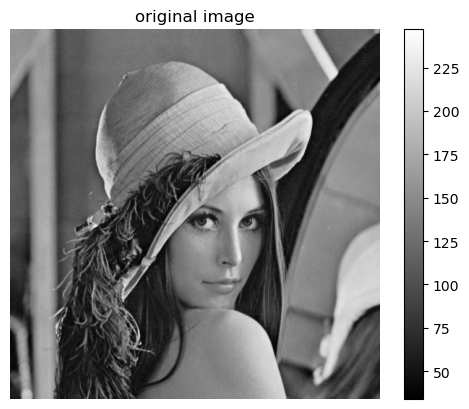

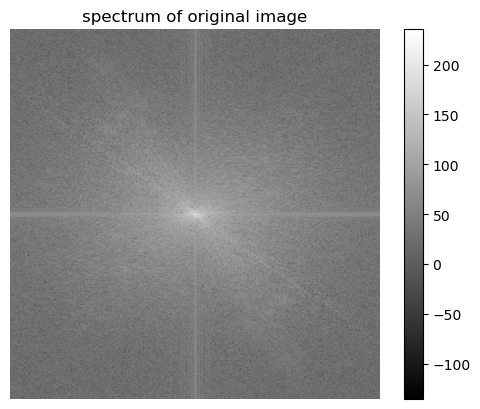

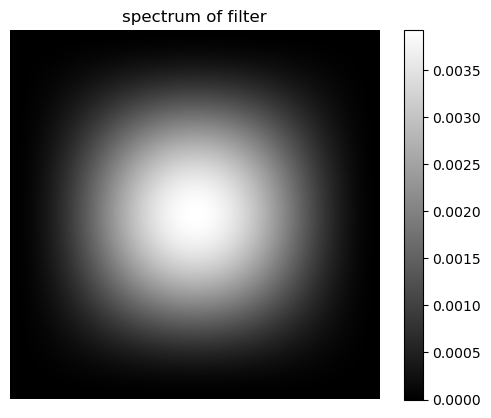

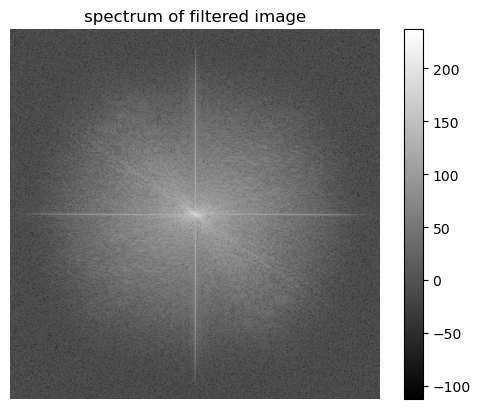

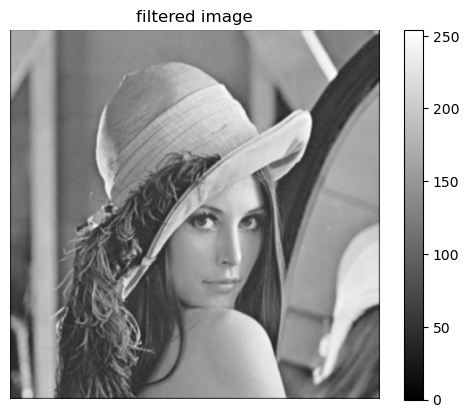

In [5]:
H1 = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])
plot_filtering(image, H1)

This is a low pass filter and it can be used for noise removal or image smoothing. The fitered image is blurrier and less grainy. The frequency resonse of the filter has values concentrated at the center. The frequency response of the image after the filtration is also more concentrated in the center compared to before the filtration.

![H2](1c_filters_H2.png)

512 512 3 3
(512, 512)
(516, 516)
(514, 514)


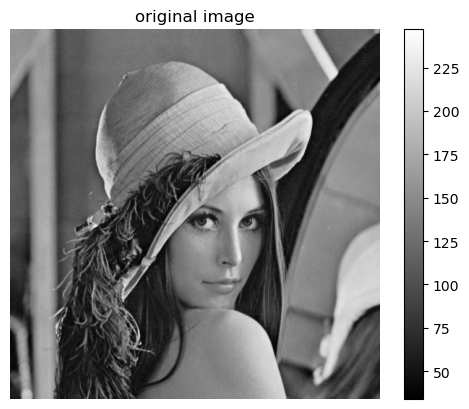

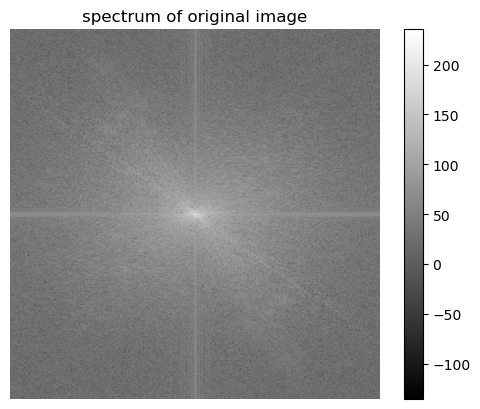

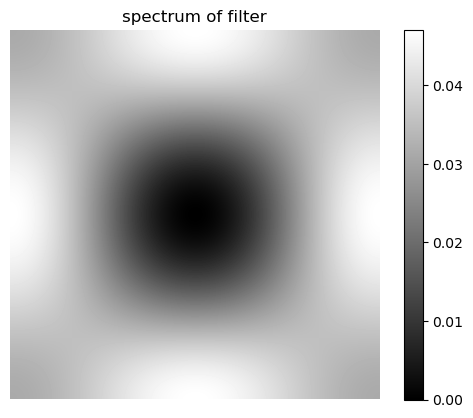

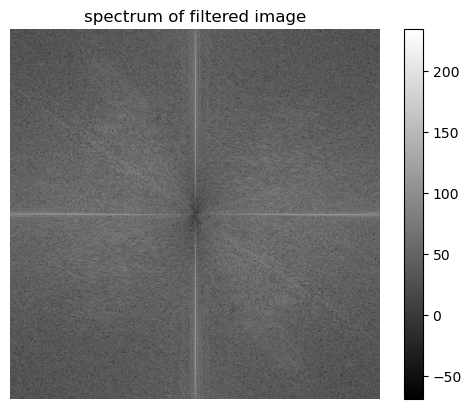

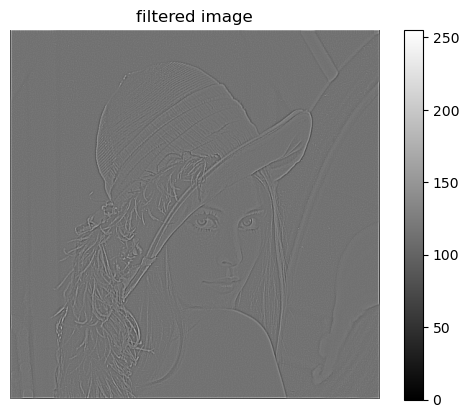

In [6]:
H2 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
plot_filtering(image, H2)

This is a high pass filter and is used for edge detection. The filtered image has removed most of the detail in the original image except for all of the edges irrespective of their orientation. The frequency response of the filter seems to has nothing in the center and lower values on the corners while higer values on the sides and top. This would indicate that the signal woould be best at detected horizonal and vertical edges and also diagonal edges. The frequency response of the filtered image also exhibits a similar trend compared to before filtering.
![H3](1c_filters_H3.png)

512 512 3 3
(512, 512)
(516, 516)
(514, 514)


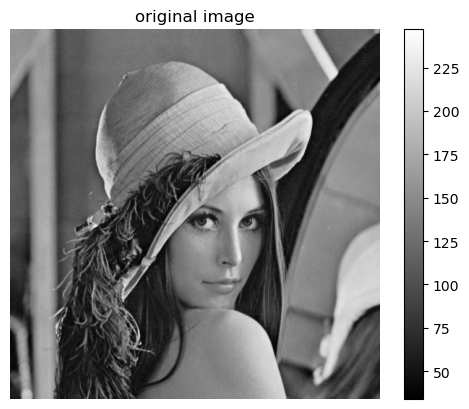

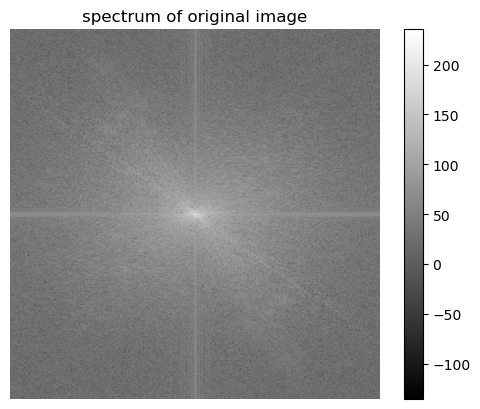

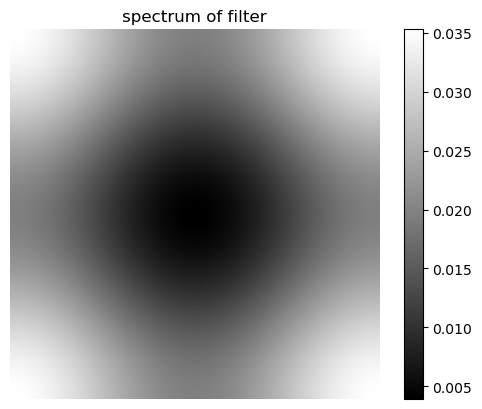

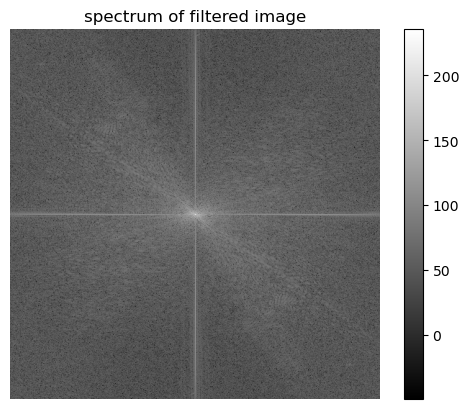

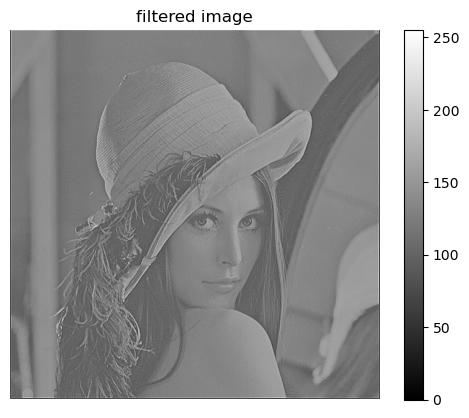

In [7]:
H3 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
plot_filtering(image, H3)

This is a high emphasis filter and is used for edge sharping. The filtered image has lower contrast than the |original image but more pronounced less blurry edges. The frequency response of the filter is lowest in the center and on the sides, while highest in the corners. In the frequency domain, the filtered image looks to have a much more distinction between the vertical and horizonal stright lines compared to other areas of the filtered image compared to before.

### **Problem 2**  (Image denoising with average and Gaussian filters).
#### (a) Write a function `awgn` that takes in an input image and noise-level and adds i.i.d<sup>2</sup> zero-mean Gaussian random noise with standard-deviation.

In [8]:
def awgn(image,sigma):
    image = image + sigma*np.random.randn(np.shape(image)[0],np.shape(image)[1])
    return (image-np.amin(image))*1/(np.amax(image)-np.amin(image))

#### (b) Write a `function gaussian_filter` which returns a 2D Gaussian filter of size m x m.

In [9]:
def gaussian_filter(m,sigma):
    x = np.arange(-(m-1)/2,(m+1)/2)
    gauss = np.exp(-x**2/(2*sigma**2))
    gauss2 = np.empty((m,m))
    for i in range(m):
        for j in range(m):
            gauss2[i][j] = gauss[i]*gauss[j]
    return gauss2/np.sum(gauss2)

#### (c) Generate a noisy version of an image using awgn, with a noise-level an = 0:1 on an image intensity scale of [0, 1]. Apply separately a Gaussian filter of size 5 x 5 and average-filter of size 5 x 5, and comment on how the filters compare in their noise-removal, qualitatively. Repeat this for a few different noise-levels and filter sizes. Each time, calculate the PSNR<sup>3</sup> of your noisy and denoised images

In [10]:
def psnr(img1,img2):
    mse = ((img1-img2)**2).mean()
    return -10*np.log10(mse)

#### Generating a noisy version of an image with noise-level = 0.1, and a 5x5 filter

512 512 5 5
(512, 512)
(520, 520)
(516, 516)


ValueError: operands could not be broadcast together with shapes (512,512) (516,516) 

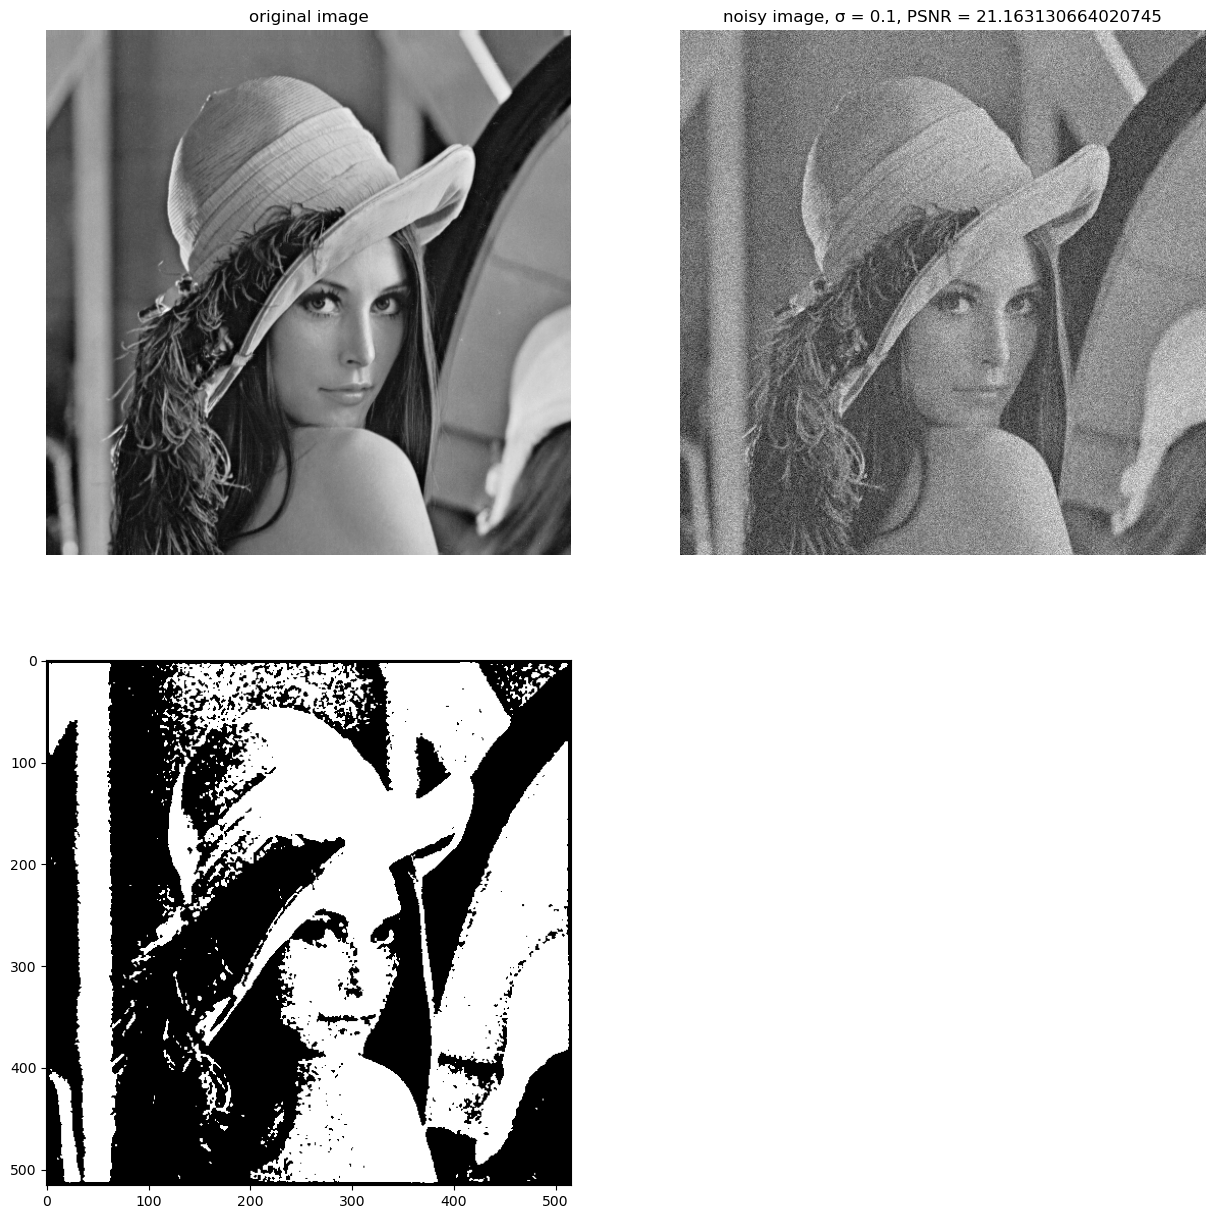

In [11]:
img = cv2.imread('lena_gray.bmp',0)
img = img/255 #Normalizing the image down to an intensity of [0,1]
img_noisy1 = awgn(img,0.1)
filt_gauss_5x5 = gaussian_filter(5,1)
filt_avg_5x5 = 1/25*np.ones((5,5))
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
plt.imshow(img,cmap='gray')
plt.title('original image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(img_noisy1,cmap='gray')
plt.title('noisy image, σ = 0.1, PSNR = '+str(psnr(img,img_noisy1)))
plt.axis('off')
plt.subplot(2,2,3)
img_gauss = conv2(img_noisy1,filt_gauss_5x5)
plt.imshow(img_gauss,cmap='gray')
plt.title('5x5 gaussian filter ~N(0,1) PSNR = '+str(psnr(img,img_gauss)))
plt.axis('off')
plt.axis('off')
plt.subplot(2,2,4)
img_avg = conv2(img_noisy1,filt_avg_5x5)
plt.imshow(img_avg,cmap='gray')
plt.title('5x5 average filter, PSNR = '+str(psnr(img,img_avg)))
plt.axis('off')
plt.axis('off')

#### Different Noise Levels

In [ ]:
noise_levels = [0.1, 0.2, 0.5, 1, 10]
plt.figure(figsize = (15,15))
plt.subplot(3,2,1)
plt.imshow(img,cmap='gray')
plt.title('original image')
plt.axis('off')
s = 2
for n in noise_levels:
    img_noisy = awgn(img,n)
    plt.subplot(3,2,s)
    plt.imshow(img_noisy,cmap='gray')
    plt.title('noisy image, σ = '+str(n)+', PSNR = '+str(psnr(img,img_noisy)))
    plt.axis('off')
    s += 1

#### Different Gauss Filters Sizes

In [ ]:
filer_sizes = [3, 5, 9, 15]
plt.figure(figsize = (15,15))
plt.subplot(3,2,1)
plt.imshow(img,cmap='gray')
plt.title('original image')
plt.axis('off')
img_noisy = awgn(img,0.2)
plt.subplot(3,2,2)
plt.imshow(img_noisy,cmap='gray')
plt.title('noisy image, σ = '+str(0.2)+', PSNR = '+str(psnr(img,img_noisy)))
plt.axis('off')
s = 3
for f in filer_sizes:
    filt = gaussian_filter(f,1)
    img_gauss = conv2(img_noisy,filt)
    plt.subplot(3,2,s)
    plt.imshow(img_gauss,cmap='gray')
    plt.title(str(f)+'x'+str(f)+ ' gaussian filter PSNR = '+str(psnr(img,img_gauss)))
    plt.axis('off')
    s += 1

#### Different Average Filters Sizes

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(3,2,1)
plt.imshow(img,cmap='gray')
plt.title('original image')
plt.axis('off')
img_noisy = awgn(img,0.2)
plt.subplot(3,2,2)
plt.imshow(img_noisy,cmap='gray')
plt.title('noisy image, σ = '+str(0.2)+', PSNR = '+str(psnr(img,img_noisy)))
plt.axis('off')
s = 3
for f in filer_sizes:
    filt = filt = (1/f**2)*(np.ones([f,f]))
    img_avg = conv2(img_noisy,filt)
    plt.subplot(3,2,s)
    plt.imshow(img_avg,cmap='gray')
    plt.title(str(f)+'x'+str(f)+ ' average filter PSNR = '+str(psnr(img,img_avg)))
    plt.axis('off')
    s += 1